# Assignment 2: DenseNet with CIFAR10 Dataset by TensorFlow

In this assignment, you are required to implement DenseNet to classify images from the [CIFAR10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) by using TensorFlow with Keras. DenseNet is very well-known and therefore it has been implemented and pre-trained by Keras. You are also required to load and test the pre-trained models, and compare them with your models.

First of all, read the DenseNet paper. DenseNet was originally proposed in 2016 by Gao Huang, Zhuang Liu, Laurens van der Maaten, Kilian Q. Weinberger in the following paper:
https://arxiv.org/abs/1608.06993

The process will be broken down into the following steps:
>
1. Answer a short question about DenseNet. (10 marks)
2. Load and visualize the data.
3. Implement your models. (30 marks)
4. Train and evaluate your models. (25 marks)
5. Load the pre-trained models from Keras and evaluate them. (15 marks)
6. Analysis your results. (20 marks)

---
## 1. Answer a short question (20 marks)

Now that you know what DenseNet is all about, let's compare it to VGG.
Both VGG and DenseNet papers describe several variations of their models that differ by their depth.
For example, VGG16 and VGG19, DenseNet-121 and DenseNet-169 are four examples from these papers.

Aside from difference in network depth, how is the architecture of DenseNet different from that of VGG? Please enter your answer in the next cell (approximately 100-200 words, both English and Chinese are acceptable).

Answer:VGG的整个网络由卷积层和全连接层叠加而成，整个结构只有3*3的卷积盒，连续的卷积层后使用池化层隔开，结构简洁，是一种直接映射的思想。相比之下DenseNet引入了残差结构（ResNet），其网络结构主要由DenseBlock和TransitionLayer组成，DenseBlock使用的是一种比ResNet更加密集的连接方式，每一层都以一种前馈输入的方式其他每层相连接，实现了特征重用，TransitionLayer通过卷积和池化改变特征图大小。

---
## 2. Load and visualize the data.

The data is directly loaded into memory.

In [1]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

num_classes = 10

# load the CIFAR10 data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# input image dimensions
input_shape = x_train.shape[1:]

# mormalize data
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

# convert class vectors to binary class matrices.
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

170498071/170498071 [==============================] - 6s 0us/step
x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)


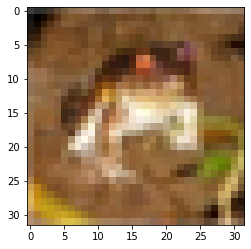

In [2]:
import matplotlib.pyplot as plt
plt.imshow(x_train[0])

## 3. Implement your models (30 marks)

In this task, you are required to implement DenseNet-41 and DenseNet-49 with compression and bottleneck as depicted in the original paper. DenseNet-41 and DenseNet-49 follow the architecture of DenseNet and remove several convolution layers for time efficiency. Specifically, DenseNet-41 and DenseNet-49 have a group of 4 Dense Block, each has a set of [3,6,6,3] and [4,6,8,4] mini-block including a 1x1 conv follow by a 3x3 conv. For more details, please refer to Table 1 in the original paper.

In [3]:
import tensorflow as tf

# 实现 conv_block
def conv_block(x, growth_rate, dropout_rate):
  # 带有Bottleneck结构 BN-relu-Conv2D(1*1)-dropout-BN-relu-Conv2D(3*3)-dropout
  x = tf.keras.layers.BatchNormalization()(x)    # 标准化
  x = tf.keras.layers.Activation('relu')(x)      # relu激活
  x = tf.keras.layers.Convolution2D(             # 卷积 
      filters = growth_rate*4,
      kernel_size = (1, 1)
  )(x)
  x = tf.keras.layers.Dropout(dropout_rate)(x)

  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)
  x = tf.keras.layers.Convolution2D(             # 卷积
      filters = growth_rate,
      kernel_size = (3, 3),
      padding='same'
  )(x)
  x = tf.keras.layers.Dropout(dropout_rate)(x)   # dropout
  return x

# 实现DenseBlock
def dense_block(x, block_layers, block_channels, growth_rate, dropout_rate):
  # 多个conv_block组成一个dense_block
  for i in range(block_layers):
    block = conv_block(x, growth_rate, dropout_rate)    # 一个conv_block
    x = tf.keras.layers.concatenate([block, x])         # 连接起前面的层
    block_channels += growth_rate                       # 通道数增加
    return x, block_channels

# 实现TransitionLayer
def trans_layer(x, block_channels, dropout_rate, compression_rate):
  # 带有compression的结构  BN-relu-Conv2D(compression_rate)-dropout-AvgPool
  x = tf.keras.layers.BatchNormalization()(x)      # 标准化
  x = tf.keras.layers.Activation('relu')(x)        # relu激活
  x = tf.keras.layers.Convolution2D(               # 卷积 
      filters = int(compression_rate*block_channels),
      kernel_size = (1, 1),
      padding='same'
  )(x)
  x = tf.keras.layers.Dropout(dropout_rate)(x)
  x = tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(x)
  return x

# 实现densenet-bc
def DenseNetBC(inputs_shape, block_channels, block_layers, growth_rate, dropout_rate, compression_rate):
  inputs = tf.keras.layers.Input(inputs_shape)
  # 1.卷积层：3×3 conv
  x = tf.keras.layers.Convolution2D(             # 卷积 
      filters = block_channels,
      kernel_size = (3, 3),
      padding='same'
  )(inputs)

  # 2.DenseBlock- TransitionLayer  D-T-D-T-D-T-D
  for i in range(3):
    # 稠密层 dense_block
    x, block_channels = dense_block(x, block_layers[i], block_channels, growth_rate, dropout_rate)
    # 过渡层 transition_layer
    x = trans_layer(x, block_channels, dropout_rate, compression_rate)
    block_channels = block_channels*compression_rate
  x, block_channels = dense_block(x, block_layers[3], block_channels, growth_rate, dropout_rate)
 
  # 3.BN+relu+GAvgPool+Dense
  x = tf.keras.layers.BatchNormalization()(x)      # 标准化
  x = tf.keras.layers.Activation('relu')(x)        # relu激活
  x = tf.keras.layers.GlobalAveragePooling2D()(x)  # GAvgPool
  x = tf.keras.layers.Dense(10)(x)                 # dense
  outputs = tf.keras.layers.Activation('softmax')(x)
  return tf.keras.models.Model(inputs, outputs)

In [4]:
# implement the code of your DenseNet-41 model here.
densenet_bc_41 = DenseNetBC([32, 32, 3], 64, [3,6,6,3], 32, 0.4, 0.5)

In [5]:
# implement the code of your DenseNet-49 model here.
densenet_bc_49 = DenseNetBC([32, 32, 3], 64, [4,6,8,4], 32, 0.4, 0.5)

---
## 4. Train and evaluate your models. (25 marks)

### 4.1 Train your models. (20 marks)

In [6]:
# train densenet_bc_41
densenet_bc_41.compile(loss=tf.keras.losses.categorical_crossentropy ,optimizer=tf.keras.optimizers.Adam(learning_rate=0.001) ,metrics=['accuracy'])
history1 = densenet_bc_41.fit(x_train, y_train, epochs=100 , batch_size=64 , validation_data=(x_test, y_test))

Epoch 1/100
782/782 [==============================] - 32s 28ms/step - loss: 1.5531 - accuracy: 0.4260 - val_loss: 1.8494 - val_accuracy: 0.3849
Epoch 2/100
782/782 [==============================] - 21s 27ms/step - loss: 1.2173 - accuracy: 0.5568 - val_loss: 1.8658 - val_accuracy: 0.4499
Epoch 3/100
782/782 [==============================] - 22s 28ms/step - loss: 1.0962 - accuracy: 0.6043 - val_loss: 1.5054 - val_accuracy: 0.5038
Epoch 4/100
782/782 [==============================] - 22s 29ms/step - loss: 1.0178 - accuracy: 0.6340 - val_loss: 1.3467 - val_accuracy: 0.5322
Epoch 5/100
782/782 [==============================] - 22s 28ms/step - loss: 0.9710 - accuracy: 0.6512 - val_loss: 1.4835 - val_accuracy: 0.5580
Epoch 6/100
782/782 [==============================] - 22s 28ms/step - loss: 0.9400 - accuracy: 0.6649 - val_loss: 1.7581 - val_accuracy: 0.4828
Epoch 7/100
782/782 [==============================] - 21s 27ms/step - loss: 0.9072 - accuracy: 0.6759 - val_loss: 1.2129 - val_ac

In [11]:
# train densenet_bc_49
densenet_bc_49.compile(loss=tf.keras.losses.categorical_crossentropy ,optimizer=tf.keras.optimizers.Adam(lr=0.001) ,metrics=['accuracy'])
history2 = densenet_bc_49.fit(x_train, y_train, epochs=100 , batch_size=64 , validation_data=(x_test, y_test))

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
782/782 [==============================] - 24s 29ms/step - loss: 1.5725 - accuracy: 0.4200 - val_loss: 1.5931 - val_accuracy: 0.4295
Epoch 2/100
782/782 [==============================] - 22s 28ms/step - loss: 1.2339 - accuracy: 0.5506 - val_loss: 1.7877 - val_accuracy: 0.4647
Epoch 3/100
782/782 [==============================] - 22s 29ms/step - loss: 1.1039 - accuracy: 0.6029 - val_loss: 2.0411 - val_accuracy: 0.4216
Epoch 4/100
782/782 [==============================] - 22s 28ms/step - loss: 1.0272 - accuracy: 0.6307 - val_loss: 2.0531 - val_accuracy: 0.4158
Epoch 5/100
782/782 [==============================] - 22s 28ms/step - loss: 0.9844 - accuracy: 0.6457 - val_loss: 1.7982 - val_accuracy: 0.4918
Epoch 6/100
782/782 [==============================] - 22s 29ms/step - loss: 0.9423 - accuracy: 0.6635 - val_loss: 1.9440 - val_accuracy: 0.4392
Epoch 7/100
782/782 [==============================] - 22s 28ms/step - loss: 0.9085 - accuracy: 0.6746 - val_loss: 1.0108 - val_ac

### 4.2 Test your models. (5 marks)

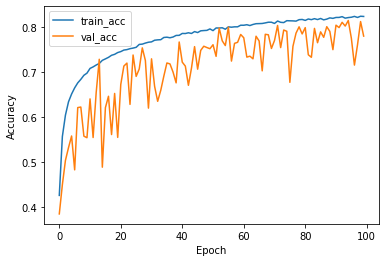

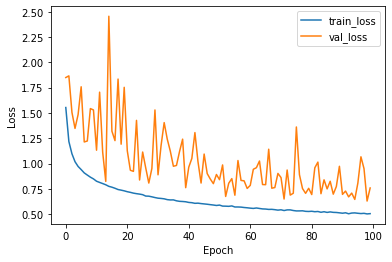

In [12]:
from matplotlib import pyplot as plt
# test densenet_bc_41
# 绘制训练过程中的准确率
plt.plot(history1.history['accuracy'], label='train_acc')
plt.plot(history1.history['val_accuracy'], label='val_acc')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# 绘制训练过程中的loss
plt.plot(history1.history['loss'], label='train_loss')
plt.plot(history1.history['val_loss'], label='val_loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

313/313 [==============================] - 2s 6ms/step - loss: 0.7582 - accuracy: 0.7799
test_loss: 0.7581694722175598
test_accuracy: 0.7799000144004822
313/313 [==============================] - 1s 4ms/step


Text(0, 0.5, 'Predict')

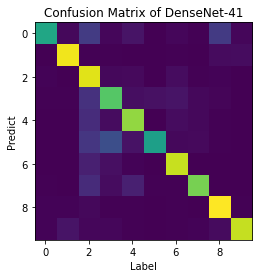

In [32]:
from sklearn.metrics import confusion_matrix
# densenet_bc_41模型评估
loss, accuracy = densenet_bc_41.evaluate(x_test, y_test)
print('test_loss: {}'.format(loss))
print('test_accuracy: {}'.format(accuracy))
predict = densenet_bc_41.predict(x_test)
pre_list = []
y_list = [] 
for pre in predict:
  pre_list.append(pre.argmax())
for y in y_test:
  y_list.append(y.argmax())
# 绘制混淆矩阵
conf_matrix1 = confusion_matrix(y_list, pre_list)
plt.imshow(conf_matrix1)
plt.title('Confusion Matrix of DenseNet-41')
plt.xlabel('Label')
plt.ylabel('Predict')

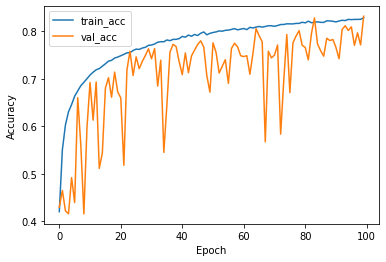

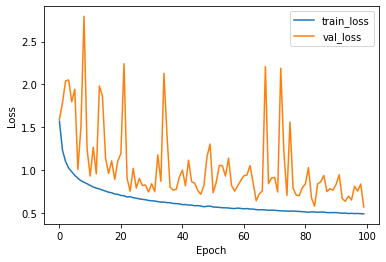

In [16]:
# test densenet_bc_49
# 绘制训练过程中的准确率
plt.plot(history2.history['accuracy'], label='train_acc')
plt.plot(history2.history['val_accuracy'], label='val_acc')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# 绘制训练过程中的loss
plt.plot(history2.history['loss'], label='train_loss')
plt.plot(history2.history['val_loss'], label='val_loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

313/313 [==============================] - 2s 6ms/step - loss: 0.5740 - accuracy: 0.8319
test_loss: 0.5740002393722534
test_accuracy: 0.8319000005722046
313/313 [==============================] - 2s 5ms/step


Text(0, 0.5, 'Predict')

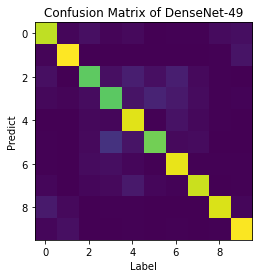

In [31]:
# densenet_bc_49模型评估
loss, accuracy = densenet_bc_49.evaluate(x_test, y_test)
print('test_loss: {}'.format(loss))
print('test_accuracy: {}'.format(accuracy))
predict = densenet_bc_49.predict(x_test)
pre_list = []
y_list = [] 
for pre in predict:
  pre_list.append(pre.argmax())
for y in y_test:
  y_list.append(y.argmax())
# 绘制混淆矩阵
conf_matrix2 = confusion_matrix(y_list, pre_list)
plt.imshow(conf_matrix2)
plt.title('Confusion Matrix of DenseNet-49')
plt.xlabel('Label')
plt.ylabel('Predict')

---
## 5. Load the pre-trained models from Keras and evaluate them. (15 marks)

Use the pre-trained DenseNet-121 model from keras and fine-tune them by adding a few fc layers at the end. You should set the parameter weights='imagenet', rather than None, to use the pretrained weights.

In [34]:
from tensorflow.keras.applications.densenet import DenseNet121

# densenet_121训练
densenet121_model = tf.keras.models.Sequential()
densenet_121 = DenseNet121(
    weights="imagenet",
    include_top=False,
    input_shape=[32, 32, 3],
    pooling='avg',
    classes=10,
)
densenet121_model.add(densenet_121)
densenet121_model.add(tf.keras.layers.Dense(10, activation='softmax'))
densenet121_model.compile(
    optimizer="adam",
    loss='categorical_crossentropy',
    metrics=['accuracy'])
history3 = densenet121_model.fit(x_train, y_train, epochs=100 , batch_size=64 , validation_data=(x_test, y_test))

Epoch 1/100
782/782 [==============================] - 61s 62ms/step - loss: 0.9637 - accuracy: 0.6782 - val_loss: 1.0018 - val_accuracy: 0.6761
Epoch 2/100
782/782 [==============================] - 45s 58ms/step - loss: 0.8461 - accuracy: 0.7233 - val_loss: 0.8567 - val_accuracy: 0.7075
Epoch 3/100
782/782 [==============================] - 45s 58ms/step - loss: 0.6823 - accuracy: 0.7710 - val_loss: 1.3179 - val_accuracy: 0.5549
Epoch 4/100
782/782 [==============================] - 45s 58ms/step - loss: 0.5498 - accuracy: 0.8133 - val_loss: 0.7252 - val_accuracy: 0.7724
Epoch 5/100
782/782 [==============================] - 47s 60ms/step - loss: 0.4195 - accuracy: 0.8557 - val_loss: 74.7621 - val_accuracy: 0.3134
Epoch 6/100
782/782 [==============================] - 45s 58ms/step - loss: 0.6286 - accuracy: 0.7910 - val_loss: 0.8151 - val_accuracy: 0.7733
Epoch 7/100
782/782 [==============================] - 46s 58ms/step - loss: 0.3852 - accuracy: 0.8661 - val_loss: 0.5847 - val_a

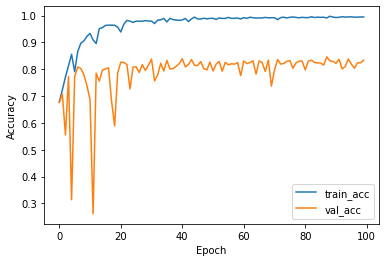

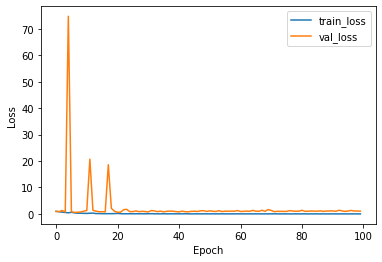

In [35]:
# densenet_121测试
# 绘制训练过程中的准确率
plt.plot(history3.history['accuracy'], label='train_acc')
plt.plot(history3.history['val_accuracy'], label='val_acc')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# 绘制训练过程中的loss
plt.plot(history3.history['loss'], label='train_loss')
plt.plot(history3.history['val_loss'], label='val_loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

313/313 [==============================] - 8s 18ms/step - loss: 1.0614 - accuracy: 0.8338
test_loss: 1.0613607168197632
test_accuracy: 0.8338000178337097
313/313 [==============================] - 6s 14ms/step


Text(0, 0.5, 'Predict')

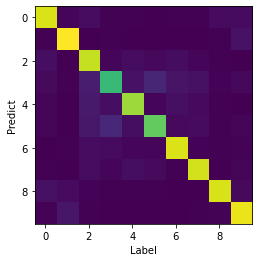

In [37]:
# densenet_bc_41模型评估
loss, accuracy = densenet121_model.evaluate(x_test, y_test)
print('test_loss: {}'.format(loss))
print('test_accuracy: {}'.format(accuracy))
predict = densenet121_model.predict(x_test)
pre_list = []
y_list = [] 
for pre in predict:
  pre_list.append(pre.argmax())
for y in y_test:
  y_list.append(y.argmax())

# 绘制混淆矩阵
conf_matrix3 = confusion_matrix(y_list, pre_list)
plt.imshow(conf_matrix3)
plt.xlabel('Label')
plt.ylabel('Predict')

---
## 6. Analysis your results. (20 marks)
Compare the performance of your models with the following analysis. Both English and Chinese answers are acceptable.
1. Is your implementation of DenseNet-49 better than DenseNet-41? If yes, how is the improvement? If no, try to figure the reason out based on your experiments. (10 marks)

Answer:从实验结果上看模型DenseNet-49要优于DenseNet-41，主要有以下几点：
- DenseNet-49最终在测试集上分类准确率为83.19%，而DenseNet-41的模型分类准确率77.99%，相差5.2%
- DenseNet-49最终在测试集上分类loss为0.5740，而DenseNet-41为0.7582，，DenseNet-49要小0.1842
- 从混淆矩阵上看，DenseNet-49模型在对角线上的颜色较深，表明分类效果好
- 训练过程的准确率和loss在验证集上均有较大的波动，虽引入了dropout，但是均存在一定的过拟合现象，而DenseNet-49过拟合更加严重一些

2. Compare the results of your implementations with the pre-trained DenseNet-121 models from Keras. (10 marks)

Answer:从实验结果上看预训练的DenseNet-121最终在CIFAR数据测试集上的准确率为83.38%，略高于DenseNet-49（0.19%），在训练的过程中，由于带有预训练过程，因此在训练中能够较快收敛，虽然验证集loss有波动，存在过拟合现象，但随着训练的逐步推动，逐步稳定，没有DenseNet-41和DenseNet-49波动大。

